In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [2]:
def inference(model, x, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        out = model(x)
    return out

def generate_left_right_ssc(model, left_img, right_img, device):
    ssc_pred_left = inference(model, build_monoscene_input(left_img), device)
    ssc_pred_left = torch.argmax(ssc_pred_left, dim=1)[0,:,:,:]
    ssc_pred_left = ssc_pred_left.squeeze(0)
    ssc_pred_right = inference(model, build_monoscene_input(right_img), device)
    ssc_pred_right = torch.argmax(ssc_pred_right, dim=1)[0,:,:,:]
    ssc_pred_right = ssc_pred_right.squeeze(0)
    return ssc_pred_left, ssc_pred_right

In [5]:
sys.path.append("/workspace/HKU-OccNet/")
from utils import SemanticKITTIDataset
from utils import visualize_labeled_array3d
from utils import plot_tensor2d
from torch.utils.data import random_split
from utils.monoscene_utils import *

KITTI_DIR = "/workspace/Dataset/dataset"



train_set = SemanticKITTIDataset(root_dir=KITTI_DIR, mode='train', 
                                 sequences=['00'], split_ratio=0.1)





num_classes = len(train_set.class_names)
class_weights = train_set.class_weights

img_width, img_height = 1241, 376



calib = read_calib("/workspace/HKU-OccNet/calib.txt")

#get_projections(img_width, img_height, calib)

In [7]:
from monoscene.monoscene import MonoScene
from utils.monoscene_utils import *

pretrained_weight_path = '/workspace/PretrainedWeights/monoscene_kitti.ckpt'


monoscene_pt = MonoScene.load_from_checkpoint(
        pretrained_weight_path,
        dataset="kitti",
        n_classes=20,
        feature = 64,
        project_scale = 2,
        full_scene_size = (256, 256, 32),
)

def build_monoscene_input(img):
    img = img.unsqueeze(0)
    batch_dict = get_projections(img_width, img_height, calib)
    for key in batch_dict:
        batch_dict[key] = batch_dict[key].unsqueeze(0)
        batch_dict[key] = batch_dict[key].to(device)
    batch_dict["img"] = img.to(device)
    return batch_dict

for p in monoscene_pt.parameters():
     p.requires_grad = False



class MonoScene(nn.Module):
    def __init__(self, MonoScene_pretrained, calib, img_width, img_height):
        super(MonoScene, self).__init__()

        self.monoscene_pt = MonoScene_pretrained
        self.batch_dict = get_projections(img_width, img_height, calib)
        for key in self.batch_dict:
            self.batch_dict[key] = self.batch_dict[key].unsqueeze(0)
            self.batch_dict[key] = self.batch_dict[key].to(device)
        
    
    # input_tensor 'x' should be batched stereo image tensor with
    # shape: N x 2 x C x H x W, where N is the batch size, 
    # 2 for left and right images, 
    # and C,H,W are the dimensions of RGB images 
    def forward(self, x):
        #print(x.shape)

        self.batch_dict["img"] = x.to(device)

        x = self.monoscene_pt(self.batch_dict)
        return x
        
        
        
        
print("Number of parameters (in millions):", sum(p.numel() for p in monoscene_pt.parameters()) / 1_000_000, 'M')

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/PretrainedWeights/monoscene_kitti.ckpt'

In [5]:
#left_img, right_img, voxel_labels = train_set.__getitem__(66)

In [6]:
# #device = 'cpu'
# ssc_pred_left = inference(monoscene_pt, build_monoscene_input(left_img), device)
# ssc_pred_left = torch.argmax(ssc_pred_left, dim=1)[0,:,:,:]
# ssc_pred_left = ssc_pred_left.squeeze(0)
# visualize_labeled_array3d(ssc_pred_left.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

In [7]:
# #device = 'cpu'
# ssc_pred_right = inference(monoscene_pt, build_monoscene_input(right_img), device)
# ssc_pred_right = torch.argmax(ssc_pred_right, dim=1)[0,:,:,:]
# ssc_pred_right = ssc_pred_right.squeeze(0)
# visualize_labeled_array3d(ssc_pred_right.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

In [8]:
# left_ssc, right_ssc = generate_left_right_ssc(monoscene_pt, left_img, right_img, device)
# print(left_ssc.shape)
# print(right_ssc.shape)

In [9]:
# voxel_labels.shape

In [10]:
# left_ssc = left_ssc.cpu()
# right_ssc = right_ssc.cpu()
# pass

In [11]:
# plot_tensor2d(left_ssc.sum(dim=2).unsqueeze(0).cpu())

In [12]:
# plot_tensor2d(voxel_labels.sum(dim=2).unsqueeze(0).cpu())

In [13]:
# voxel_labels.unsqueeze(0).shape

In [14]:
# tensor = left_ssc.float()
# # Reshape tensor to [256, 1, 256, 32]
# tensor_reshaped = tensor.unsqueeze(1)

# # Apply average pooling
# avg_pooled_tensor = F.avg_pool2d(tensor_reshaped, (1, 32)).squeeze(1)
# avg_pooled_tensor = avg_pooled_tensor.permute(2, 0, 1)


In [15]:
# plot_tensor2d(avg_pooled_tensor)

In [16]:
# tensor = voxel_labels.float()
# # Reshape tensor to [256, 1, 256, 32]
# tensor_reshaped = tensor.unsqueeze(1)

# # Apply average pooling
# max_pooled_tensor = F.max_pool2d(tensor_reshaped, (1, 32)).squeeze(1).permute(2, 0, 1)
# plot_tensor2d(max_pooled_tensor)

In [17]:
# max_pooled_tensor.shape

In [18]:
# # Freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the newly added layers (if any)
# for param in model.fc.parameters():
#     param.requires_grad = True


In [19]:
num_classes = len(train_set.class_names)
class_weights = train_set.class_weights

train_len = len(train_set)
split_idx = int(0.9 * train_len)
train_subset, val_subset = random_split(train_set, [split_idx, train_len - split_idx])

train_dataloader = DataLoader(train_subset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=1, shuffle=True)



print(len(train_dataloader))
print(len(val_dataloader))



408
46


In [20]:
#!pip install deformable-attention

import torch
import torch.nn as nn
import torchvision.ops.feature_pyramid_network as fpn
from collections import OrderedDict
from transformers import DetrFeatureExtractor, DetrForSegmentation

# load pretrained detr & remove last layers
detr_seg_pt = DetrForSegmentation.from_pretrained('facebook/detr-resnet-50-dc5-panoptic')
for param in detr_seg_pt.parameters():
     param.requires_grad = False
detr_seg_pt = torch.nn.Sequential(OrderedDict([*(list(detr_seg_pt.named_children())[:-2])]))
detr_seg_pt.detr = torch.nn.Sequential(OrderedDict([*(list(detr_seg_pt.detr.named_children())[:-2])]))




import torch
from deformable_attention import DeformableAttention

from utils import sem_scal_loss, geo_scal_loss, CE_ssc_loss
from utils import Header


class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # Cross-Attention
        attn_output, _ = self.multihead_attn(query, key_value, key_value)
        # Add & Norm (Residual Connection and Layer Normalization)
        query = self.norm1(query + attn_output)
        return query


class UpsampleBEV(nn.Module):
    def __init__(self):
        super(UpsampleBEV, self).__init__()
        self.initial_fc = nn.Linear(1024, 16*8*8)

        # Upsample and Convolution layers
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(2, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.initial_fc(x)
        x = x.view(-1, 16, 8, 8)

        # Apply upsampling and convolution layers
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.upsample(x)

        # Adjust channels to 3
        x = self.final_conv(x)
        return x    

class VoxelFeatureExtractor(nn.Module):
    def __init__(self):
        super(VoxelFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool = nn.MaxPool3d((1, 1, 2), stride=(1, 1, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.adaptive_pool = nn.AdaptiveMaxPool3d((256, 256, 1))
        self.conv3 = nn.Conv3d(32, 1, kernel_size=(1, 1, 1), stride=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = torch.sigmoid(self.conv3(x))
        # Remove the singleton dimension
        x = x.squeeze(3)
        return x



    
    
# Stereo Forward-Backword BEV Occupancy Prediction Network 
class STF_BEV_Occ(nn.Module):
    def __init__(self, detr_seg_pt, monoscene_pt, class_weights):
        super(STF_BEV_Occ, self).__init__()
        # out feat shape [1, 100, 256] [100, 256], having 100 elements (like object queries or spatial positions) 
        # for a single sample in the batch, with each element having a feature vector of size 256
        self.backbone = detr_seg_pt 
        self.monoscene = monoscene_pt
        self.class_weights = class_weights
        
        self.conv1 = nn.Conv2d(256, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1600, 1024)
        
        self.conv3 = nn.Conv2d(256, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(1600, 1024)
        
        self.cross_attn = CrossAttention(embed_dim = 1024, num_heads = 8)
        self.upsample = UpsampleBEV()
        
        self.vox_feat = VoxelFeatureExtractor()
        self.dim_reduce = nn.Sequential(
            nn.Conv2d(2, 3, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128
            nn.Conv2d(3, 5, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            nn.Conv2d(5, 5, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x32
        )

        self.fc3 = nn.Linear(320, 4096 * 3)
        
        self.deconv_net = nn.Sequential(
            nn.ConvTranspose3d(3, 5, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.ConvTranspose3d(5, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.ConvTranspose3d(8, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU()
        )
        
        
        self.header = Header(class_num=20, feature=32)
        
        
        
        
        #self.mse_loss = nn.MSELoss()
    
    #inputs are all in bacthed format
    def forward(self, left_img, right_img): #, depth_disp, sem_seg
        xl = self.backbone(left_img).last_hidden_state
        xl = xl.view(-1, 256, 10, 10)  
        xl = self.relu(self.conv1(xl))
        xl = self.relu(self.conv2(xl))
        xl = self.flatten(xl)
        xl = self.relu(self.fc1(xl))
        
        #xd = self.backbone(depth)
        
        xr = self.backbone(right_img).last_hidden_state
        xr = xr.view(-1, 256, 10, 10)  
        xr = self.relu(self.conv3(xr))
        xr = self.relu(self.conv4(xr))
        xr = self.flatten(xr)
        xr = self.relu(self.fc2(xr))
        
        stereo_attn_feat = self.cross_attn(xl, xr)
        #print(stereo_attn_feat.shape)
        x = self.upsample(stereo_attn_feat)
        x = F.max_pool2d(x.permute(0, 2, 3, 1), kernel_size=(1, 3), stride=(1, 3)).permute(0, 3, 1, 2)
        
        
        #x = self.flatten(x)
        #print(x.shape) #torch.Size([1, 65536])
        
        
        left_sc = self.monoscene(left_img)
        x_sc = torch.argmax(left_sc, dim=1)
        
        sc_feat = self.vox_feat(x_sc.float()).unsqueeze(1)
        
        x = torch.cat((x, sc_feat), dim=1)
        
        x = self.dim_reduce(x)

        x = self.flatten(x)
        
        x = self.relu(self.fc3(x)) 
        x = x.view(-1, 3, 32, 32, 4)
        x = self.deconv_net(x)
        
        x = x[:,:,:-1,:-1,:-1]
        x = self.header(x)
        
        #x = x + left_sc
        
        return x
    
    def step(self, left_img, right_img, voxel_labels):
        left_img = left_img.to(device)
        right_img = right_img.to(device)
        voxel_pred_1h = model(left_img, right_img)

        voxel_labels = voxel_labels.float().to(device)

        loss = sem_scal_loss(voxel_pred_1h, voxel_labels)
        loss += geo_scal_loss(voxel_pred_1h, voxel_labels)
        class_weights = self.class_weights
        class_weights = class_weights.float().to(device)
        loss += CE_ssc_loss(voxel_pred_1h, voxel_labels, class_weights)
        return loss
    
#     def step(self, left_img, right_img):
#         left_img = left_img.to(device)
#         right_img = right_img.to(device)
#         BEV_pred = model(left_img, right_img)
        
#         BEV_labels = voxel_labels.sum(dim=3).float()
#         BEV_labels = BEV_labels.view(-1, 256*256)
#         BEV_labels = BEV_labels.to(device)
        
        
#         loss = self.mse_loss(BEV_pred, BEV_labels)
#         return loss


In [21]:
monoscene = MonoScene(monoscene_pt, calib, img_width, img_height)
model = STF_BEV_Occ(detr_seg_pt, monoscene, class_weights)
print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters()) / 1_000_000, 'M')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Number of parameters (in millions): 203.600741 M


In [22]:
# left_img, right_img, voxel_labels = train_set.__getitem__(66)

# left_img = left_img.unsqueeze(0).to(device)
# right_img = right_img.unsqueeze(0).to(device)
# voxel_labels.to(device)
# model = model.to(device)


# out = model(left_img, right_img)

In [23]:
# out.shape

In [24]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.01)
num_epochs = 50
best_loss = np.inf

model = model.to(device)

In [25]:
from tqdm import tqdm
import torch.nn.functional as F


for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (left_img, right_img, voxel_labels) in tqdm(enumerate(train_dataloader),total = len(train_dataloader)):
        loss = model.step(left_img, right_img, voxel_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for (left_img, right_img, voxel_labels) in tqdm(val_dataloader):
            loss = model.step(left_img, right_img, voxel_labels)
            optimizer.zero_grad()
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'bevocc.pth')
        best_loss = (train_loss / len(train_dataloader))

  0%|          | 0/408 [00:00<?, ?it/s]/workspace/HKU-OccNet/monoscene/monoscene.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  projected_pix // scale_2d,
/workspace/HKU-OccNet/monoscene/monoscene.py:107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  projected_pix // scale_2d,
100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 1: Training loss: 10.165523519702987, Validation loss: 9.939981315446937


100%|██████████| 46/46 [00:37<00:00,  1.21it/s]


Epoch 2: Training loss: 9.763076050608765, Validation loss: 9.73488359865935


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 3: Training loss: 9.665363265018836, Validation loss: 9.718477539394213


100%|██████████| 46/46 [00:37<00:00,  1.24it/s]


Epoch 4: Training loss: 9.624984487599017, Validation loss: 9.786431426587312


100%|██████████| 46/46 [00:37<00:00,  1.24it/s]


Epoch 5: Training loss: 9.584338932645087, Validation loss: 9.776013529818991


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 6: Training loss: 9.549415012200674, Validation loss: 9.736027168190997


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 7: Training loss: 9.50758189313552, Validation loss: 9.698631182960842


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 8: Training loss: 9.499015259976481, Validation loss: 9.82934830499732


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 9: Training loss: 9.588937085048824, Validation loss: 9.592698553334111


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 10: Training loss: 9.312917449895073, Validation loss: 9.542546479598336


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 11: Training loss: 9.205639187027426, Validation loss: 9.600607643956723


 62%|██████▏   | 251/408 [03:39<02:16,  1.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 46/46 [00:37<00:00,  1.24it/s]


Epoch 16: Training loss: 8.854514276280122, Validation loss: 9.958461377931679


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 17: Training loss: 8.80269481154049, Validation loss: 9.921282146288002


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 18: Training loss: 8.756254969858656, Validation loss: 10.141593539196512


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 19: Training loss: 8.738530629990148, Validation loss: 10.040321754372638


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 20: Training loss: 8.857861950116998, Validation loss: 10.108281581298165


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 21: Training loss: 8.712659432607538, Validation loss: 10.171524379564369


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 22: Training loss: 8.64549206051172, Validation loss: 10.384283076161923


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 23: Training loss: 8.625662698465234, Validation loss: 10.504728027012037


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 24: Training loss: 8.609000499342002, Validation loss: 10.759614052979842


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 25: Training loss: 8.590187466612049, Validation loss: 10.897336151288902


100%|██████████| 46/46 [00:38<00:00,  1.20it/s]


Epoch 26: Training loss: 8.560538308293212, Validation loss: 10.415879208108652


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 27: Training loss: 8.547936965437497, Validation loss: 10.818503265795501


100%|██████████| 46/46 [00:37<00:00,  1.24it/s]


Epoch 28: Training loss: 8.51469429217133, Validation loss: 11.122378121251645


100%|██████████| 46/46 [00:37<00:00,  1.21it/s]


Epoch 29: Training loss: 8.5086784806906, Validation loss: 10.848782145458719


100%|██████████| 46/46 [00:39<00:00,  1.18it/s]


Epoch 30: Training loss: 8.50684982771967, Validation loss: 11.00604512380517


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 31: Training loss: 8.491905982587852, Validation loss: 10.721539932748545


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 32: Training loss: 8.457382301489512, Validation loss: 11.398322509682696


100%|██████████| 46/46 [00:37<00:00,  1.21it/s]


Epoch 33: Training loss: 8.459621791746102, Validation loss: 10.92407871329266


100%|██████████| 46/46 [00:37<00:00,  1.21it/s]


Epoch 34: Training loss: 8.434875450882258, Validation loss: 11.17464970505756


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 35: Training loss: 8.427204321412479, Validation loss: 11.167462234911712


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 36: Training loss: 8.422629453387914, Validation loss: 11.127529175385185


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 37: Training loss: 8.421348728385626, Validation loss: 11.105094598687213


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 38: Training loss: 8.405677389864827, Validation loss: 11.12176896178204


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 39: Training loss: 8.411346713701883, Validation loss: 11.036497375239497


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 40: Training loss: 8.396670534330255, Validation loss: 11.22756168116694


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 41: Training loss: 8.378509452529983, Validation loss: 11.701986924461696


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 42: Training loss: 8.393187878178615, Validation loss: 11.300634270128997


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


Epoch 43: Training loss: 8.359078553377413, Validation loss: 11.572233220805293


100%|██████████| 46/46 [00:37<00:00,  1.23it/s]


Epoch 44: Training loss: 8.346046582156537, Validation loss: 11.559399801751841


100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


Epoch 45: Training loss: 8.344709935141545, Validation loss: 11.535278164822122


100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


Epoch 46: Training loss: 8.339360501251969, Validation loss: 11.834853410720825


100%|██████████| 46/46 [00:37<00:00,  1.21it/s]


Epoch 47: Training loss: 8.358142699681077, Validation loss: 11.85023217615874


100%|██████████| 46/46 [00:38<00:00,  1.20it/s]


Epoch 48: Training loss: 8.335949286526324, Validation loss: 11.274579939634904


100%|██████████| 46/46 [00:38<00:00,  1.20it/s]


Epoch 49: Training loss: 8.32023093513414, Validation loss: 11.71598922688028


 66%|██████▌   | 270/408 [03:56<02:00,  1.14it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 for epoch in range(num_epochs):                                                             │
│    6 │   train_loss = 0.0                                                                        │
│    7 │   for i, (left_img, right_img, voxel_labels) in tqdm(enumerate(train_dataloader),total    │
│ ❱  8 │   │   loss = model.step(left_img, right_img, voxel_labels)                                │
│    9 │   │                                                                                       │
│   10 │   │   optimizer.zero_grad()                                                               │
│   11 │   │   loss.backward()                                                                     │
│                                                                                                  │
│ in step:207                                                                                      │
│                                                                                                  │
│   204 │   │                                                                                      │
│   205 │   │   voxel_labels = voxel_labels.float().to(device)                                     │
│   206 │   │                                                                                      │
│ ❱ 207 │   │   loss = sem_scal_loss(voxel_pred_1h, voxel_labels)                                  │
│   208 │   │   loss += geo_scal_loss(voxel_pred_1h, voxel_labels)                                 │
│   209 │   │   class_weights = self.class_weights                                                 │
│   210 │   │   class_weights = class_weights.float().to(device)                                   │
│                                                                                                  │
│ /workspace/HKU-OccNet/utils/ssc_loss.py:77 in sem_scal_loss                                      │
│                                                                                                  │
│    74 │   │                                                                                      │
│    75 │   │   # Remove unknown voxels                                                            │
│    76 │   │   target_ori = ssc_target                                                            │
│ ❱  77 │   │   p = p[mask]                                                                        │
│    78 │   │   target = ssc_target[mask]                                                          │
│    79 │   │                                                                                      │
│    80 │   │   completion_target = torch.ones_like(target)                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [8]:
test_set = SemanticKITTIDataset(root_dir=KITTI_DIR, mode='test', 
                                 sequences=['00'], split_ratio=0.8)
left_img, right_img, voxel_labels = train_set.__getitem__(5)

In [38]:
out = model(left_img.unsqueeze(0).to(device), right_img.unsqueeze(0).to(device))

/workspace/HKU-OccNet/monoscene/monoscene.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  projected_pix // scale_2d,
/workspace/HKU-OccNet/monoscene/monoscene.py:107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  projected_pix // scale_2d,


In [39]:
out.shape

torch.Size([1, 20, 256, 256, 32])

In [40]:
voxel_pred = torch.argmax(out, dim=1)[0,:,:,:]

visualize_labeled_array3d(voxel_pred.detach().cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [41]:
ssc_pred_left = inference(monoscene_pt, build_monoscene_input(left_img), device)
ssc_pred_left = torch.argmax(ssc_pred_left, dim=1)[0,:,:,:]
ssc_pred_left = ssc_pred_left.squeeze(0)
visualize_labeled_array3d(ssc_pred_left.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [9]:
visualize_labeled_array3d(voxel_labels.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [ ]:
# out_np = out.to('cpu').view(1, 256, 256).detach()
# plot_tensor2d(out_np)

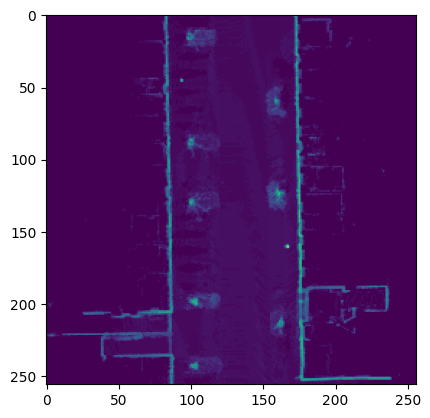

In [43]:
plot_tensor2d(voxel_labels.sum(dim=2).unsqueeze(0).cpu())